# preprocessing

In [12]:
import os
import pandas as pd
import librosa
import numpy as np
import pickle

## read data 


In [2]:
data_dir = '..\data\sample1\words'
# List to store all loaded data
audio_data = []
press_times = []

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    # Check if the file is a .wav file
    if filename.endswith('.wav'):
        # Load the audio file
        filepath = os.path.join(data_dir, filename)
        audio, sr = librosa.load(filepath, sr=None)  # Load with original sampling rate
        
        # Extract the word index to find the corresponding .xlsx file
        word_index = filename.split('_')[1].split('.')[0]
        if word_index == '0':
            continue
        
        xlsx_filename = f'word_{word_index}.xlsx'
        
        # Load the corresponding Excel file
        xlsx_filepath = os.path.join(data_dir, xlsx_filename)
        timestamps = pd.read_excel(xlsx_filepath)
        
        # Store audio data and timestamps
        audio_data.append((audio, sr))
        press_times.append(timestamps)

## feature extraction (melspectrogram)

In [3]:
def extract_features(audio, sr, n_mels=64, hop_length=512):
    """
    Extracts Mel spectrogram features from audio.
    
    Parameters:
    - audio: Audio signal (numpy array)
    - sr: Sampling rate of the audio
    - n_mels: Number of Mel bands
    - hop_length: Number of samples between successive frames
    
    Returns:
    - mel_spectrogram: Mel spectrogram features
    - times_ms: Times of each frame in milliseconds
    """
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Convert frames to time in milliseconds
    times = librosa.frames_to_time(np.arange(mel_spectrogram_db.shape[1]), sr=sr, hop_length=hop_length)
    # times_ms = times * 1000  # Convert to milliseconds
    times_ms = times
    
    return mel_spectrogram_db, times_ms

# Extract features for each audio file
features = []
times_list = []
for (audio, sr), timestamps in zip(audio_data, press_times):
    mel_features, times_ms = extract_features(audio, sr)
    features.append(mel_features)
    times_list.append(times_ms)

## show one example 

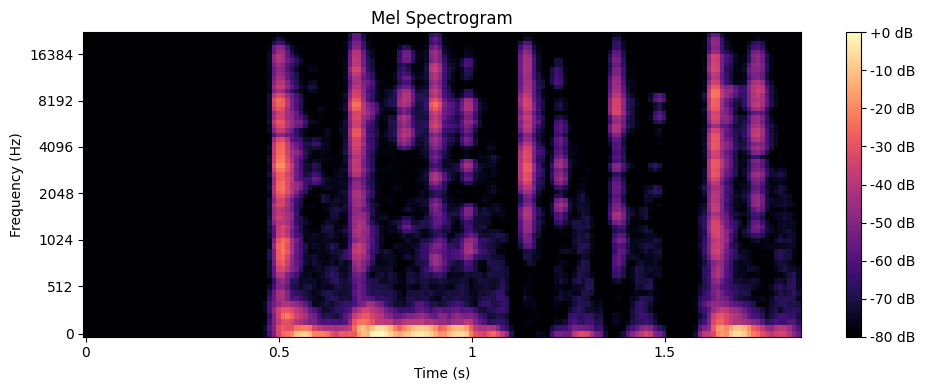

In [4]:
import matplotlib.pyplot as plt
import librosa.display

# Choose an example to plot (e.g., the first one)
example_mel_spectrogram = features[4]  # Change index if you want to see a different one

# Plotting the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(example_mel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## data labeling

In [5]:
def label_audio(times_ms, timestamps, window_size=50):
    """
    Labels each time frame in the audio based on key press timestamps.
    
    Parameters:
    - times_ms: Times of each frame in milliseconds
    - timestamps: DataFrame with key press times
    - window_size: Time window in milliseconds to mark a key press as "active"
    
    Returns:
    - labels: Binary labels (1 for key press, 0 for no key press) for each frame
    """
    labels = np.zeros(len(times_ms))
    press_times = timestamps['down'].values  # Assuming column is 'time_in_ms'

    window_size = times_ms[1] - times_ms[0]
    
    for press_time in press_times:
        # Find frames within the window around the key press time
        window_start = press_time - window_size / 2
        window_end = press_time + window_size / 2
        active_frames = np.where((times_ms >= window_start) & (times_ms <= window_end))[0]
        
        # Label those frames as 1 (key pressed)
        labels[active_frames] = 1
    
    return labels

# Label the data
labels = []
for times_ms, timestamps in zip(times_list, press_times):
    labels.append(label_audio(times_ms, timestamps))

In [7]:
labels[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [8]:
len(features[0])

64

In [9]:
features[5].shape

(64, 166)

In [67]:
def create_training_windows(features, labels, window_size=25):
    """
    Segments features and labels into training windows.
    
    Parameters:
    - features: Mel spectrogram features
    - labels: Binary labels for each frame
    - window_size: Number of frames in each training window
    
    Returns:
    - X: List of feature windows
    - y: List of corresponding label windows
    """
    X, y = [], []
    for i in range(0, len(features) - window_size, window_size):
        X.append(features[:, i:i + window_size])
        y.append(labels[i:i + window_size])
    
    return np.array(X), np.array(y)

# Generate training windows for each audio file
X_train, y_train = [], []
for mel_features, label in zip(features, labels):
    X, y = create_training_windows(mel_features, label)
    X_train.append(X)
    y_train.append(y)

# Stack all windows into a single array
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)


In [68]:
X_train.shape, y_train.shape

((40, 64, 25), (2, 500))

In [13]:
def prepare_framewise_data(features, labels):
    """
    Flattens each time step of the Mel spectrogram into an independent training sample.
    
    Parameters:
    - features: List of Mel spectrograms (one per audio sample)
    - labels: List of binary label arrays (one per audio sample)
    
    Returns:
    - X: 2D array where each row is a frame (frequency bins) from all audio samples
    - y: 1D array with binary labels for each frame
    """
    X, y = [], []
    
    for mel_features, label in zip(features, labels):
        # Flatten along time axis
        X.append(mel_features.T)  # Transpose so each row is a time frame (n_mels,)
        y.append(label)
    
    # Concatenate all frames and labels into single arrays
    X = np.vstack(X)
    y = np.hstack(y)
    
    return X, y

# Prepare the frame-wise data
X_train, y_train = prepare_framewise_data(features, labels)

# Save the data to disk
output_dir = r'../data/model_data'
np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)

# Alternative: Saving as pickle
with open(os.path.join(output_dir, 'training_data.pkl'), 'wb') as f:
    pickle.dump((X_train, y_train), f)

print("Data saved successfully.")

Data saved successfully.


In [14]:
X_train.shape

(2756, 64)

In [15]:
y_train.shape   

(2756,)

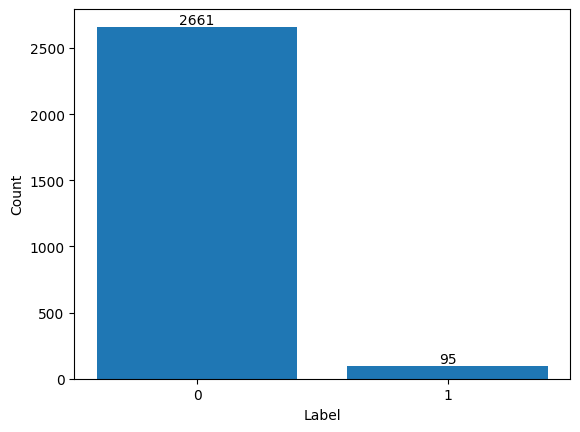

In [18]:
# plot a bar chart that counts the number of 1s and 0s in the y_train array

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, tick_label=[0, 1])

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(unique[i], count, str(count), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')

plt.show()
